Label to ID mapping: {'Cyber Bullying  Stalking  Sexting': 0, 'Fraud CallVishing': 1, 'UPI Related Frauds': 2, 'FakeImpersonating Profile': 3, 'Profile Hacking Identity Theft': 4, 'Other': 5, 'Provocative Speech for unlawful acts': 6, 'EWallet Related Fraud': 7, 'DebitCredit Card FraudSim Swap Fraud': 8, 'Internet Banking Related Fraud': 9, 'Sexually Explicit Act': 10, 'Data Breach/Theft': 11, 'Unauthorised AccessData Breach': 12, 'Cheating by Impersonation': 13, 'Website DefacementHacking': 14, 'Cryptocurrency Fraud': 15, 'RapeGang Rape RGRSexually Abusive Content': 16, 'Malware Attack': 17, 'SQL Injection': 18, 'Online Job Fraud': 19, 'Email Hacking': 20, 'Sexually Obscene material': 21, 'Online Gambling  Betting': 22, 'DematDepository Fraud': 23, 'Hacking/Defacement': 24, 'EMail Phishing': 25, 'Tampering with computer source documents': 26, 'Cyber Terrorism': 27, 'Ransomware Attack': 28, 'Online Trafficking': 29, 'Child Pornography CPChild Sexual Abuse Material CSAM': 30, 'Damage to

<Axes: title={'center': 'Train Sub-Category Distribution'}, ylabel='count'>

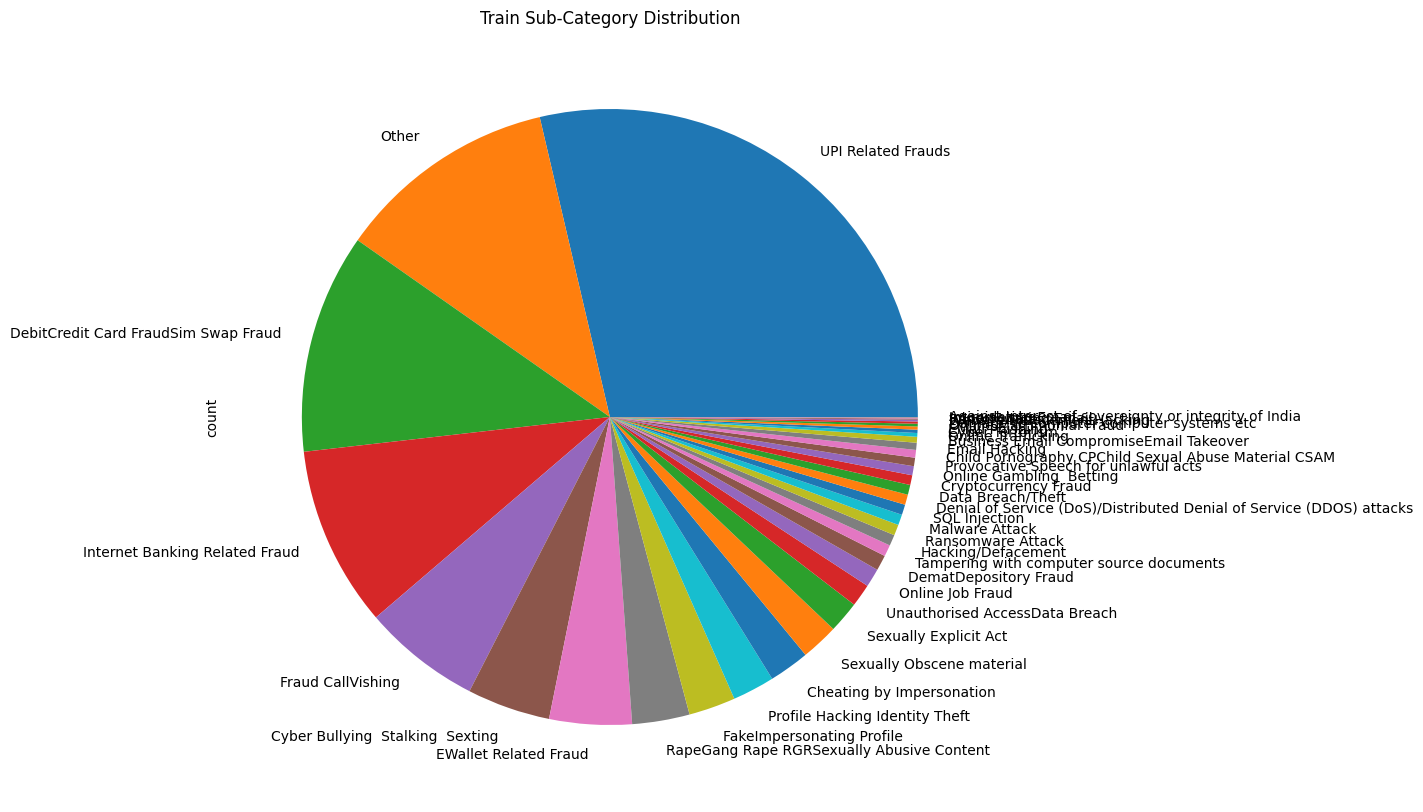

In [1]:
!pip install transformers
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
import pandas as pd

# Load DataFrames
df = pd.read_csv('/kaggle/input/birdyfinal/train.csv')
dft = pd.read_csv('/kaggle/input/birdyfinal/test.csv')

# Drop rows with NaN in 'crimeaditionalinfo' column
df = df.dropna(subset=['crimeaditionalinfo'])
dft = dft.dropna(subset=['crimeaditionalinfo'])

# Fill missing 'sub_category' values with 'category' values
df['sub_category'] = df['sub_category'].fillna(df['category'])
dft['sub_category'] = dft['sub_category'].fillna(dft['category'])

# Shuffle DataFrames
df = df.sample(frac=1.0, random_state=42)
dft = dft.sample(frac=1.0, random_state=42)

# Create label mappings
labels = df['sub_category'].unique().tolist()
labels = [s.strip() for s in labels]  # Clean up any trailing spaces

NUM_LABELS = len(labels)
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print("Label to ID mapping:", label2id)

# Map 'sub_category' values to numerical labels
df["labels"] = df['sub_category'].map(lambda x: label2id[x.strip()])
dft["labels"] = dft['sub_category'].map(lambda x: label2id.get(x.strip(), 1))  # Default to 1 if not found

# Plot distribution of labels as pie charts
df['sub_category'].value_counts().plot(kind='pie', figsize=(10, 10), title="Train Sub-Category Distribution")
#dft['sub_category'].value_counts().plot(kind='pie', figsize=(10, 10), title="Test Sub-Category Distribution")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

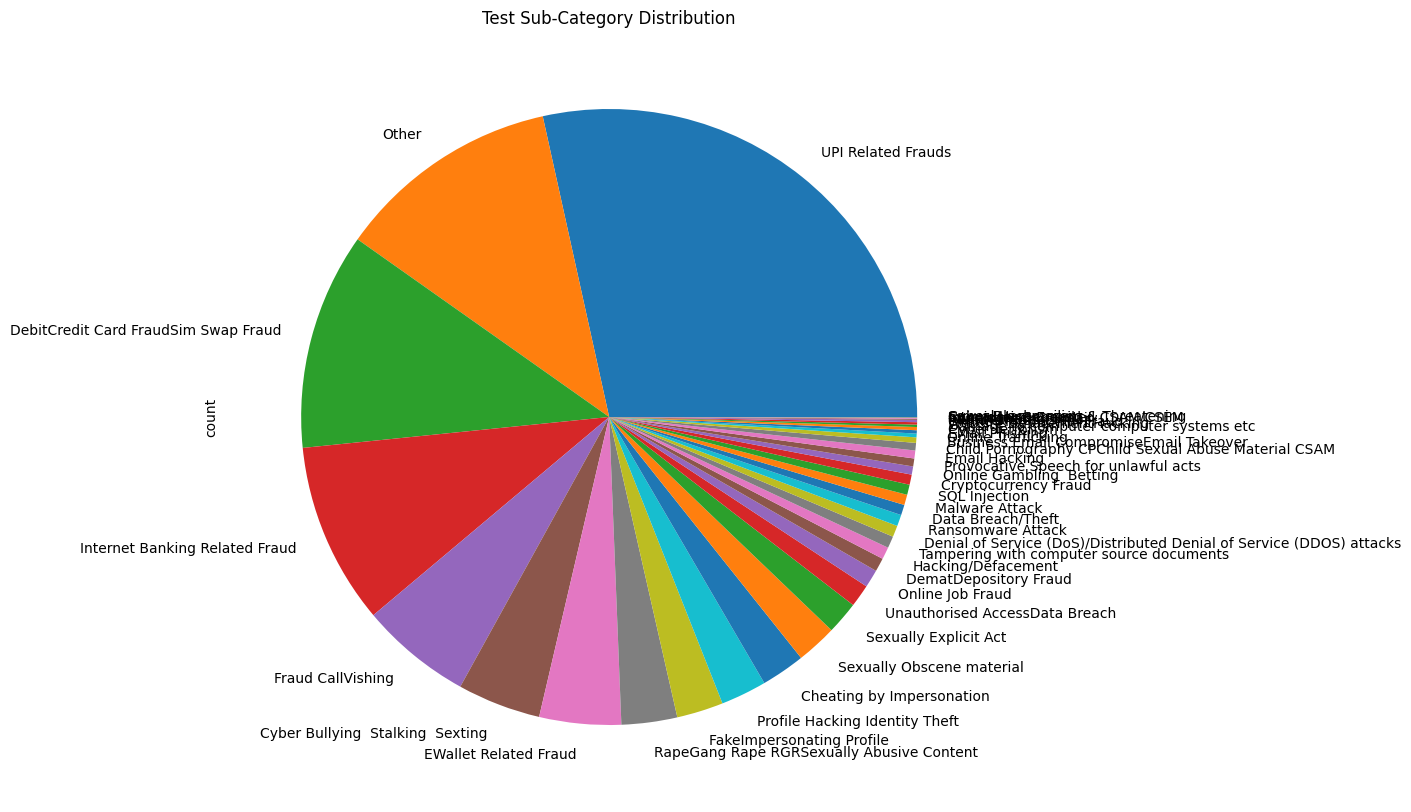

In [2]:
dft['sub_category'].value_counts().plot(kind='pie', figsize=(10, 10), title="Test Sub-Category Distribution")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [3]:
# Example tokenization to verify setup (optional step)
token = tokenizer.encode_plus(
    df['crimeaditionalinfo'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

# Initialize arrays to store token IDs and attention masks for training data
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

# Function to generate training data (token IDs and attention masks)
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['crimeaditionalinfo']), total=len(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text['input_ids']
        masks[i, :] = tokenized_text['attention_mask']
    return ids, masks

# Generate data for X (training input)
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

# Initialize arrays for test set
Y_input_ids = np.zeros((len(dft), 256))
Y_attn_masks = np.zeros((len(dft), 256))

# Generate data for Y (test input)
Y_input_ids, Y_attn_masks = generate_training_data(dft, Y_input_ids, Y_attn_masks, tokenizer)


  0%|          | 0/93665 [00:00<?, ?it/s]

  0%|          | 0/31222 [00:00<?, ?it/s]

In [4]:
# Define labels as one-hot encoded arrays for training and validation datasets
train_labels = np.zeros((len(df), 39))
train_labels[np.arange(len(df)), df['labels'].values] = 1
val_labels = np.zeros((len(dft), 39))
val_labels[np.arange(len(dft)), dft['labels'].values] = 1

# Create a mapping function
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, train_labels))
train_dataset = train_dataset.map(SentimentDatasetMapFunction)
train_dataset = train_dataset.shuffle(10000).batch(16, drop_remainder=True)

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((Y_input_ids, Y_attn_masks, val_labels))
val_dataset = val_dataset.map(SentimentDatasetMapFunction)
val_dataset = val_dataset.shuffle(10000).batch(16, drop_remainder=True)


In [5]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(39, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,   # Adjust as needed based on your dataset size
    decay_rate=0.96,     # Adjust decay rate as needed
    staircase=True       # Keeps the decay in discrete steps
)

# Create the Adam optimizer with the learning rate schedule
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the loss function and accuracy metric
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1778534   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [7]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3


I0000 00:00:1730730015.424975      76 service.cc:145] XLA service 0x7d1c82ebac80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730730015.425028      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730730015.599664      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5854/5854 [==============================] - 3204s 537ms/step - loss: 1.5971 - accuracy: 0.5082 - val_loss: 1.4461 - val_accuracy: 0.5409
Epoch 2/3
5854/5854 [==============================] - 3134s 535ms/step - loss: 1.3847 - accuracy: 0.5614 - val_loss: 1.4049 - val_accuracy: 0.5547
Epoch 3/3
5854/5854 [==============================] - 3135s 536ms/step - loss: 1.2909 - accuracy: 0.5890 - val_loss: 1.4140 - val_accuracy: 0.5530


In [8]:
sentiment_model.save('sentiment_model')
sentiment_model = tf.keras.models.load_model('sentiment_model')

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Processing rows:   0%|          | 0/31222 [00:00<?, ?it/s]

Accuracy: 0.5529754660175518
Precision: 0.5326316204636016
Recall: 0.5529754660175518
F1 Score: 0.5279457750414542


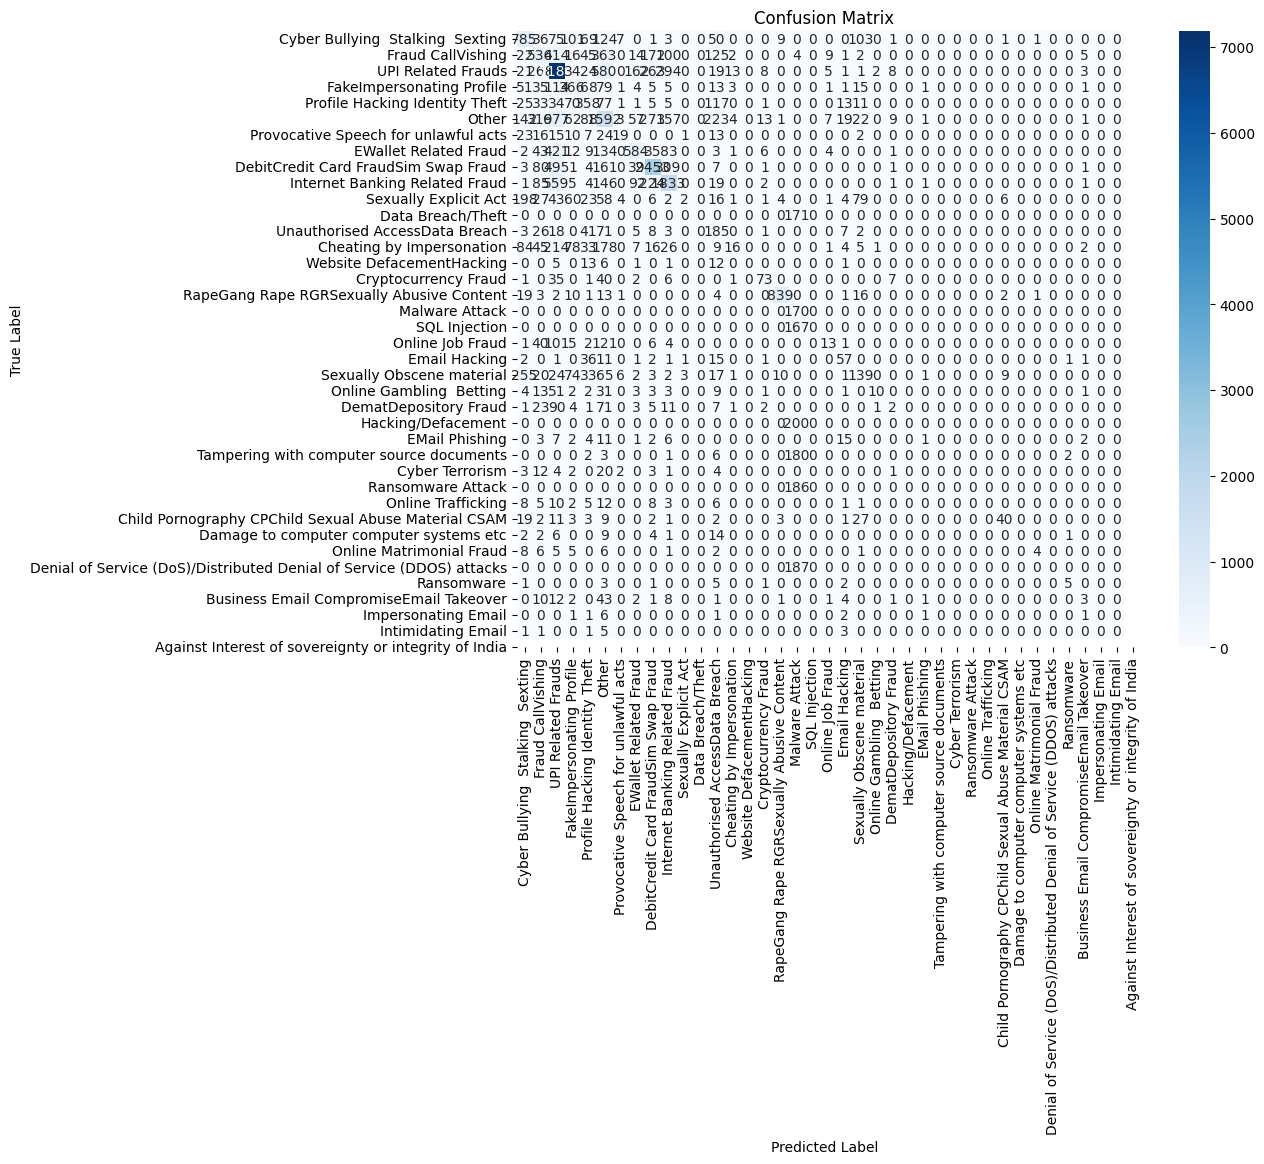

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming id2label is defined somewhere in your code
# id2label = {id: label for id, label in enumerate(labels)}

# Prepare the data for prediction
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float32),
        'attention_mask': tf.cast(token.attention_mask, tf.float32)
    }

# Make predictions with the model
def make_prediction(model, processed_data):
    probs = model.predict(processed_data, verbose=0)[0]
    return np.argmax(probs)

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop over each row in the DataFrame with tqdm for progress tracking
for idx, row in tqdm(dft.iterrows(), total=len(dft), desc="Processing rows"):
    text = row['crimeaditionalinfo']
    actual_label = row['labels']
    processed_data = prepare_data(text, tokenizer)
    predicted_class = make_prediction(sentiment_model, processed_data)
    
    # Store true and predicted labels
    y_true.append(actual_label)
    y_pred.append(predicted_class)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plotting the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))],
            cbar=True, square=True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
